# Project: Investigate a Dataset - [Dataset-name]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

This dataset collects information from 110.527 medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. 14 distinct characteristics about the patient are included in each record:
- **"PatientId":** Unique patiend identifier
- **"AppointmentID":** Unique appointment identifier
- **"Gender":** Whether the patient is male (M) or female (F)
- **"ScheduledDay":** What day the patient set up their appointment
- **"AppointmentDay":** What day the patient had to show up for the appointment (same date or after *ScheduledDay*) 
- **"Age":** The patient's age
- **"Neighborhood:** Indicates the location of the hospital
- **"Scholarship":** Flag indicating whether or not the patient is enrolled in Brasilian welfare program *Bolsa Família*
- **"Hipertension":** Flag indicating whether the patient has hipertension or not
- **"Diabetes":** Flag indicating whether the patient has Diabetes or not
- **"Alcoholism":** Flag indicating whether the patient has Alcoholism or not
- **"Handcap":** Flag indicating whether the patient has some sort of handicap or not
- **"SMS_received":** Flag indicating whether the patient received an appointment alert via SMS or not
- **"No-show":** It says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.


### Question(s) for Analysis
Below, I divide my analysis in two different blocks. The first block within the `Data Wrangling` section is divided into two additional blocks, namely `General` and `Cleaning`, here I add some generic questions that address typical issues when analyzing a dataset. The last block `Exploratory Analysis` is where the relevant questions have been placed. Here I've added specific questions to guide my analysis. The idea is that by solving these set of questions, anyone could gain a proper picture of this particular dataset.
- **Data Wrangling:**
    - **General:**
        - How many records do we have?
        - How many columns do we have?
        - What kind of datatypes are we dealing with?
        - Do we have duplicated records?
        - Do we have NAN values?

    - **Cleaning:** 
        - How are we going to deal with NAN values (impute mean/median, drop...)?
        - Do we have any date type variables? Are they clean?
        - Do we have any text/categorical variables? Are they clean?
        - Any additional variable we could come up with (i.e. for ML purposes)?
    
- **Exploratory Analysis:**
    - From when is the oldest and most recent record? From when is the oldest and most recent record?
    - Do we have daily records?
    - What are the ranges of the different independant variables?
    - What is the distribution of each variable?
    - How is the correlation between variables? Are they correlated with the dependant variable?
    - Is the number of samples balanced for negative and positive values of the dependant variable?
    - Is there any seasonality associated with not showing up to the consultation?
    - Does the number of days between schedule and actual appointment impact on the probability of showing up to the consultation?
    - Does age group or gender impact on the probability of showing up to the consultation?
    - In which places there is a higher probability to not to show up to the doctor?
    

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html


In [2]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

Requirement already up-to-date: pandas==0.25.0 in /opt/conda/lib/python3.6/site-packages (0.25.0)


In [3]:
! ls -la ./Database_No_show_appointments/

total 10512
drwxr-xr-x 2 root root     4096 Aug 11  2021 .
drwxr-xr-x 7 root root     4096 Jul 17 18:43 ..
-rw-r--r-- 1 root root 10739535 Aug 11  2021 noshowappointments-kagglev2-may-2016.csv


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load data into DataFrame
data = pd.read_csv("./Database_No_show_appointments/noshowappointments-kagglev2-may-2016.csv")

# Create copy to work with
df = data.copy()

<a id='wrangling'></a>
## Data Wrangling
### General Properties

Here we seek to answer:
    - How many records do we have?
    - How many columns do we have?
    - What kind of datatypes are we dealing with?
    - Do we have duplicated records?
    - Do we have NAN values?

In [5]:
# Quick first glance on top 5 records
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [6]:
# Check size of the dataset
df.shape

(110527, 14)

In [7]:
# Check available columns
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [8]:
# Quick check on datatypes and NAN records per variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [9]:
# Checking for duplicated values
df[df.duplicated(keep="first")].shape

(0, 14)

- The dataset contains 110527 historical records of patients with 14 columns. 

- It seems there are no NAN values in the dataset

- It seems there are no duplicated rows in the dataset

- Each column holds different type of information: 
    - **ID's:**
        - total: 2
        - pandas dtype: float & int
    - **categorical:**
        - total: 3
        - pandas dtype: object
    - **numerical:**
        - total: 7
        - pandas dtype: int
    - **datetime:** 
        - total: 2
        - pandas dtype: object

- The datetime variables will have to be casted from object type to datetime64[ns]

- The target variable *"No-show"* is unbalanced (80% of negative samples for 20% of positive samples). In addition, the pandas datetype is object so it'd be interesting to do binary encoding for advanced tasks such as Machine Learning.


### Data Cleaning
Here we seek this kind of questions:
    - How are we going to deal with NAN values (impute mean/median, drop...)?
    - Do we have any date type variables? Are they clean?
    - Do we have any text/categorical variables? Are they clean?
    - Any additional variable we could come up with (i.e. for ML purposes)?


#### Casting
- I consider that some of the datatypes are not appropariate for some of the variables. Therefore I've decided to cast them to a different type:
    - **ScheduledDay:** From string to datetime
    - **AppointmentDay:** From string to datetime
    - **PatientId:** From float to int 

In [10]:
# Clean both datetime columns by casting to appropriate format
# From '2016-04-29T00:00:00Z' string type to '2020-01-06 00:00:00+00:00' datetime[ns, UTC]
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay']= pd.to_datetime(df['AppointmentDay'])
df['ScheduledDay'].dtypes

datetime64[ns, UTC]

In [11]:
# Cast PatientID to int type
df["PatientId"] = df["PatientId"].astype("int")
df["PatientId"].dtypes

dtype('int64')

#### Encoding
- I've decided to binary encode the target variable (No-show):
    - **BEFORE:**
        - Yes: The patient did not showed up
        - No: The patient showed up
    - **AFTER:**
        - 1: The patient did not showed up
        - 0: The patient showed up

In [12]:
# Encode the target variable ("No-show")
target_mapping = {
    "Yes": 1,
    "No": 0
}
df["No-show"] = df["No-show"].apply(lambda x: target_mapping[x])

# Check the distribution
df["No-show"].value_counts(normalize=True)

0    0.798067
1    0.201933
Name: No-show, dtype: float64

#### Feature engineering
- I'll be creating 6 new variables:
    - **AppointmentYear:** The year of the scheduled visit 
    - **AppointmentMonth:** The month of the scheduled visit
    - **PatientLifeStage:** The group life stage the patient belongs to (infant, toddler, child, adult...)
    - **IsUnderAge:** If the patient is under 18 years old
    - **DaysBetweenScheduledAndAppointment:** The days between when the appointment was settled up and the date of the appointment 
    - **DistanceBetweenScheduledAndAppointmentBinGroup**: Three different groups distinguishing between those patients with less or equal than 15 days value for DaysBetweenScheduledAndAppointment, those between 16 and 30 and those with more than 30 days.

In [13]:
# Sort records by date
df.sort_values("AppointmentDay", inplace=True)
df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0
2151,725775968562,5521232,M,2016-03-29 11:09:08+00:00,2016-04-29 00:00:00+00:00,33,MARIA ORTIZ,0,0,0,0,0,1,0
2152,94755722517728,5521230,F,2016-03-29 11:08:52+00:00,2016-04-29 00:00:00+00:00,50,MARIA ORTIZ,0,0,0,0,0,0,0
2153,35387553979251,5523393,F,2016-03-29 17:04:40+00:00,2016-04-29 00:00:00+00:00,69,MARIA ORTIZ,0,0,0,0,0,1,0
2154,732498986588399,5642808,F,2016-04-29 17:21:24+00:00,2016-04-29 00:00:00+00:00,65,MARIA ORTIZ,0,0,0,0,0,0,0


In [14]:
# Create new columns from ScheduledDay variable
df["AppointmentYear"] = df["AppointmentDay"].apply(lambda x: x.year)
df["AppointmentMonth"] = df["AppointmentDay"].apply(lambda x: x.month)

In [15]:
def get_life_stage(age: int) -> str:
    """
    Returns the associated life stage string.
    
    Parameters
    ----------
    age int:
        The age that we want to convert
            
    Returns
    -------
    One of the available string stages:
            - "INFANT": 0-1 years
            - "TODDLER": 2-4 years
            - "CHILD": 5-12 years
            - "TEEN": 13-19 years
            - "ADULT": 20-39 years
            - "MIDDLE_ADULT": 40-59 years
            - "SENIOR_ADULT": >60 years
            - "UNKOWN": <0 years
    """
    if 0 <= age <= 1:
        return "INFANT"
    
    elif 2 <= age <= 4:
        return "TODDLER"
    
    elif 5 <= age <= 12:
        return "CHILD"
    
    elif 13 <= age <= 19:
        return "TEEN"
    
    elif 20 <= age <= 39:
        return "ADULT"
    
    elif 40 <= age <= 59:
        return "MIDDLE_ADULT"
    
    elif age >= 60:
        return "SENIOR_ADULT"
    
    else :
        return "UNKOWN"

    
def is_underage(age: int) -> int:
    """
    Indicates if the individual has less than 18 years or not.
    
    Parameters
    ----------
    age int:
        The age that we want to convert
            
    Returns
    -------
    1 if less than 18 years, 0 if not and -1 if negative ages
    """
    if 0 <= age < 18:
        return 1
    
    elif age >= 18:
        return 0
    
    else:
        return -1

In [16]:
# Create new variable with the individuals life stage label
df["PatientLifeStage"] = df["Age"].apply(lambda x: get_life_stage(x))

# Create new variables indicating if is underage or not (possible values)
df["IsUnderAge"] = df["Age"].apply(lambda x: is_underage(x))

## Create new variable with the difference expressed in days between the AppointmentDay and the ScheduledDay
df["DaysBetweenScheduledAndAppointment"] = df.apply(
    lambda x: (x["AppointmentDay"].date()-x["ScheduledDay"].date()).days,
    axis=1
)

# Create a new variable with bin groups for DaysBetweenScheduledAndAppointment
# Bins (INTERVAL: LABEL ): (-inf, 15]: "0_TO_15_DAYS" , (15, 30]: "16_TO_30_DAYS", (30, +inf]: "31_TO_INF_DAYS"
df["DistanceBetweenScheduledAndAppointmentBinGroup"] = pd.cut(
    x = df["DaysBetweenScheduledAndAppointment"],
    bins = [-np.inf, 15, 30, np.inf],
    labels = ["0_TO_15_DAYS", "16_TO_30_DAYS", "31_TO_INF_DAYS"]
)

In [17]:
df["IsUnderAge"].value_counts()

 0    83147
 1    27379
-1        1
Name: IsUnderAge, dtype: int64

In [18]:
df[df["DaysBetweenScheduledAndAppointment"]<0].shape

(5, 20)

In [19]:
df["DaysBetweenScheduledAndAppointment"].value_counts(normalize=True).head()

0    0.348901
2    0.060845
4    0.047862
1    0.047165
7    0.044387
Name: DaysBetweenScheduledAndAppointment, dtype: float64

In [20]:
df["DistanceBetweenScheduledAndAppointmentBinGroup"].value_counts(normalize=True)

0_TO_15_DAYS      0.762538
16_TO_30_DAYS     0.143567
31_TO_INF_DAYS    0.093896
Name: DistanceBetweenScheduledAndAppointmentBinGroup, dtype: float64

In [21]:
df[df["DaysBetweenScheduledAndAppointment"]>30].shape

(10378, 20)

In [22]:
df.shape

(110527, 20)

#### Discarding invalid samples

- There are some records (5) where the **AppointmentDay** is before the **ScheduledDay**. Since this phenom is weird (not a clear explanation why this happens and the percentage of samples is extremely low), I've decided to drop all records with negative value of **DaysBetweenScheduledAndAppointment** assuming this is due to an error. 

- There is only one record where the **Age** is negative (impossible). This could indicate that the patients age is not known. Since this is extremely rare Ive decided to drop this records as well.

In [23]:
# Filter out records where "AppointmentDay" comes before "ScheduledDay"
# Filter out records with impossible age (negative values)
df = df[(df["DaysBetweenScheduledAndAppointment"]>=0) & (df["Age"]>=0)]
df.shape

(110521, 20)

#### Drop columns
- Each record correspond to a unique **AppointmentID**. Since it does not provide any relevant information for our analysis I've decided to discard the entire column. 

In [24]:
assert(df["AppointmentID"].nunique()==len(df))

In [25]:
df.drop(columns=["AppointmentID"], inplace=True)

In [26]:
df.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,AppointmentYear,AppointmentMonth,PatientLifeStage,IsUnderAge,DaysBetweenScheduledAndAppointment,DistanceBetweenScheduledAndAppointmentBinGroup
0,29872499824296,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016,4,SENIOR_ADULT,0,0,0_TO_15_DAYS
2151,725775968562,M,2016-03-29 11:09:08+00:00,2016-04-29 00:00:00+00:00,33,MARIA ORTIZ,0,0,0,0,0,1,0,2016,4,ADULT,0,31,31_TO_INF_DAYS
2152,94755722517728,F,2016-03-29 11:08:52+00:00,2016-04-29 00:00:00+00:00,50,MARIA ORTIZ,0,0,0,0,0,0,0,2016,4,MIDDLE_ADULT,0,31,31_TO_INF_DAYS
2153,35387553979251,F,2016-03-29 17:04:40+00:00,2016-04-29 00:00:00+00:00,69,MARIA ORTIZ,0,0,0,0,0,1,0,2016,4,SENIOR_ADULT,0,31,31_TO_INF_DAYS
2154,732498986588399,F,2016-04-29 17:21:24+00:00,2016-04-29 00:00:00+00:00,65,MARIA ORTIZ,0,0,0,0,0,0,0,2016,4,SENIOR_ADULT,0,0,0_TO_15_DAYS


<a id='eda'></a>
## Exploratory Data Analysis

### From when is the oldest and latest medical appointment?
- We only have samples corresponding to appointments during a short period in 2016. The most recent appointment corresponds to 2016-06-08 while the oldest appointment corresponds to 2016-04-29. There is a difference of 40 days between both samples.

In [27]:
df["AppointmentDay"].max()

Timestamp('2016-06-08 00:00:00+0000', tz='UTC')

In [28]:
df["AppointmentDay"].min()

Timestamp('2016-04-29 00:00:00+0000', tz='UTC')

In [29]:
print(f"Days between oldest and most recent sample: {(df['AppointmentDay'].max().date()-df['AppointmentDay'].min().date()).days} days")

Days between oldest and most recent sample: 40 days


### Do we have daily records?
- We don't have daily records. As mentioned before there is a difference of 40 days between the latest and oldest appointment. However, we only have appointments for 27 different days. Therefore, there are 13 days for which there are no appointment records in our dataset. 

In [30]:
unique_days = set([timestamp.date() for timestamp in df['AppointmentDay']])
print(f"Unique sample days: {len(unique_days)} different days")

Unique sample days: 27 different days


### What are the ranges of the different numerical variables?
- Most of the variables correspond to binary flags (0's and 1's) or categories (case for **Handcap**). Variables **Age** and **DaysBetweenScheduledAndAppointment** correspond to discrete numerical values with a wider range.
- In the case of the **Age** there are a couple of details that stand out:
    - There are patients with ages ranging from 0 to 115 years
    - Mean and median values are around 37 years old.
    - 75% of the samples correspond to patients with less or equal age to 55 years.
    
- In the case of the **DaysBetweenScheduledAndAppointment** we observe that:
    - There was at least one patient that scheduled the appointment 179 days before the appointment itself.
    - On average, the patients in our sample showed up to the appointment 10 days after scheduling it.
    - Mean and median deviate a little, which could indicate higher spread and existance of outliers. It could be worth to check this out in more detail when plotting the histograms.

In [31]:
# Brief summary on general statistics for numerical variables
columns_to_describe = ["Age", "DaysBetweenScheduledAndAppointment"]
df[columns_to_describe].describe(percentiles = np.arange(0, 1, 0.25))

,Age,DaysBetweenScheduledAndAppointment
count,110521.000000,110521.000000
mean,37.089386,10.184345
std,23.109885,15.255153
min,0.000000,0.000000
0%,0.000000,0.000000
25%,18.000000,0.000000
50%,37.000000,4.000000
75%,55.000000,15.000000
max,115.000000,179.000000


### What is the distribution of each numerical variable?
- Plotting the histogram for the numerical variables reveals certain interesting aspects (some of them already anticipated in the previous section):
    - Most of the variables correspond to binary flag indicating that the patient has a disease (**Diabetes**, **Hipertension**) or addiction (**Alcoholism**). The distribution of positive and negative samples is unbalanced with higher proportion of negative (no affection).
    - The **Handcap** variable provides a number between 0 and 4 indicating whether the patient has some degree of handicap or not. 
    - We only have samples of appointments that meant to take place in 2016 between April, May (most of the samples) and June.
    - Most of the samples in our dataset correspond to adults (people above 18 years old).

In [32]:
df["Handcap"].value_counts()

0    108282
1      2040
2       183
3        13
4         3
Name: Handcap, dtype: int64

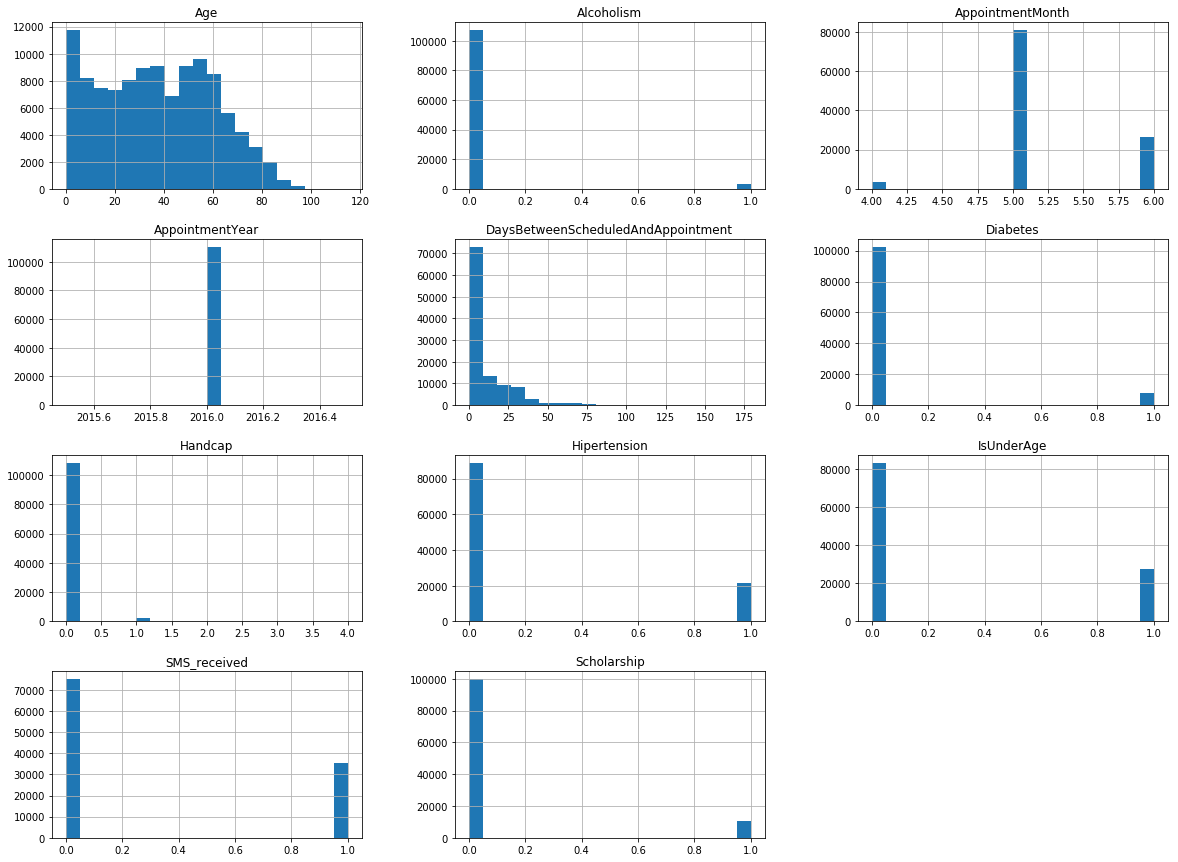

In [33]:
columns_for_distribution = ["Age", "Scholarship", "Hipertension", "Diabetes", "Alcoholism", "Handcap", "SMS_received", "AppointmentYear", "AppointmentMonth", "IsUnderAge", "DaysBetweenScheduledAndAppointment"]
df[columns_for_distribution].hist(bins=20, figsize=(20, 15))
plt.show()

### How is the correlation between variables? Are they correlated with the dependant variable?

- Slight correltions between independent variables:
    - **Diabetes** and **Hipertension** have a slight positive correlation which means that high values of one indicator happen when there are high values of the other **in this particular sample**. This does not mean that it will always happen (*causality*), since there are numerous factors that could be driving this behavior and the sample size and span is reduced.
    - **Age** has also a positively correlated with **Hipertension** and **Diabetes**.
    - There is also some positive correlation between **SMS_received** and **DaysBetweenScheduledAndAppointment**. Further analysis on the relationship between these two variables could lead us to a better understanding of the former variable: Is the SMS service automatic or does it have to be requested? Is it only meant for people with an appointment far away in time? 
    
- Slight correlation between independant and dependant variables: 
    -  The only variables that show some linear dependency with the target variable **No-show** are the **SMS_received** and the **DaysBetweenScheduledAndAppointment**. Although it is not a strong relationship and correlation is not enough to write a conclusion. It could be interesting to study the effect of **DaysBetweenScheduledAndAppointment** and the appointment default rate.

In [34]:
columns_for_correlation = ["Age", "Scholarship", "Hipertension", "Diabetes", "Alcoholism", "Handcap", "SMS_received", "IsUnderAge", "DaysBetweenScheduledAndAppointment", "No-show"]

correlation = df[columns_for_correlation].corr()
correlation.style.background_gradient(cmap='coolwarm')
correlation.style.background_gradient(cmap='coolwarm').set_precision(2)

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,IsUnderAge,DaysBetweenScheduledAndAppointment,No-show
Age,1,-0.092,0.5,0.29,0.096,0.078,0.013,-0.74,0.035,-0.06
Scholarship,-0.092,1,-0.02,-0.025,0.035,-0.0086,0.0012,0.026,-0.03,0.029
Hipertension,0.5,-0.02,1,0.43,0.088,0.08,-0.0063,-0.28,-0.017,-0.036
Diabetes,0.29,-0.025,0.43,1,0.018,0.058,-0.015,-0.16,-0.027,-0.015
Alcoholism,0.096,0.035,0.088,0.018,1,0.0047,-0.026,-0.099,-0.039,-0.00018
Handcap,0.078,-0.0086,0.08,0.058,0.0047,1,-0.024,-0.042,-0.02,-0.0063
SMS_received,0.013,0.0012,-0.0063,-0.015,-0.026,-0.024,1,-0.035,0.4,0.13
IsUnderAge,-0.74,0.026,-0.28,-0.16,-0.099,-0.042,-0.035,1,-0.022,0.024
DaysBetweenScheduledAndAppointment,0.035,-0.03,-0.017,-0.027,-0.039,-0.02,0.4,-0.022,1,0.19
No-show,-0.06,0.029,-0.036,-0.015,-0.00018,-0.0063,0.13,0.024,0.19,1


### Is the number of samples balanced for negative and positive values of the dependant variable?
- The target variable is unbalanced. In this case, the proportion of people showing up to the appointment is higher to the opposite case in our sample dataset.

In [35]:
df["No-show"].value_counts(normalize=True)

0    0.798102
1    0.201898
Name: No-show, dtype: float64

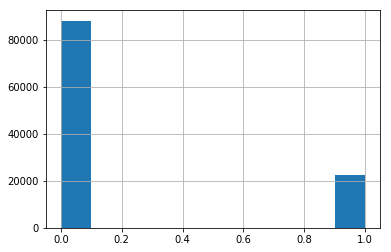

In [36]:
df["No-show"].hist()
plt.show()

### Is there any seasonality (daily, monthly) associated with not showing up to the consultation?
- The time span of our sample is limited with only 27 days between 3 different months in 2016.
- We dont have the same amount of samples for each month so we need to normalize by group
- After normalizing the positive count for each month (dividing agains the overall number of samples belonging to that month) there are no big differences between each of them.

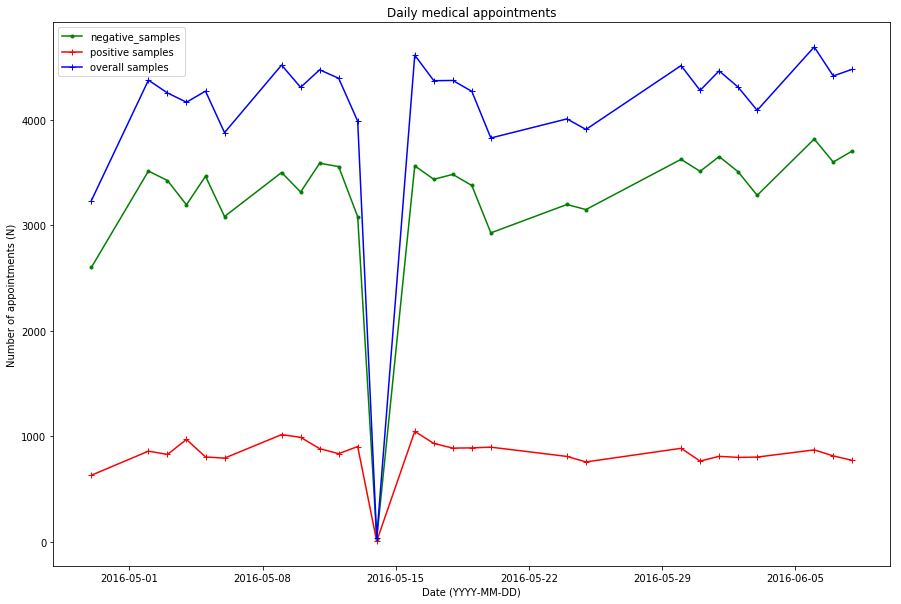

In [37]:
negative_samples_df = df[df["No-show"]==0]
positive_samples_df = df[df["No-show"]==1]

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.plot(
    negative_samples_df[["PatientId", "AppointmentDay"]].groupby("AppointmentDay").count().index,
    negative_samples_df[["PatientId", "AppointmentDay"]].groupby("AppointmentDay").count().values,
    marker='.', color='g', label= 'negative_samples'
)
ax.plot(
    positive_samples_df[["PatientId", "AppointmentDay"]].groupby("AppointmentDay").count().index,
    positive_samples_df[["PatientId", "AppointmentDay"]].groupby("AppointmentDay").count().values,
    marker='+', color='r', label= 'positive samples')

ax.plot(
    df[["PatientId", "AppointmentDay"]].groupby("AppointmentDay").count().index,
    df[["PatientId", "AppointmentDay"]].groupby("AppointmentDay").count().values,
    marker='+', color='b', label= 'overall samples')

ax.set_title("Daily medical appointments")

ax.set_xlabel("Date (YYYY-MM-DD)")

ax.set_ylabel("Number of appointments (N)")

plt.legend()

plt.show()

In [38]:
def get_normalized_value_counts(df: pd.DataFrame, column: str, target: str) -> pd.DataFrame:
    """
    This function returns an extended version of a DataFrame value_counts,
    which includes not only the overall number of samples per variable class
    but also the amount of positive samples assigned to each class, based on
    a target column and the percentage of positive samples.
    
    Parameters
    ----------
    df pd.DataFrame:
        Input data
        
    column str:
        A string indicating the column under analysis
        
    target str:
        A string indicating the name of the target column
        
    Returns
    -------
    A DataFrame with information about the amount of samples per class and
    the relative percentages where columns indicate:
        - COLUMN_CLASS: all the column classes
        - ocurrences_positive: the number of positive samples (for the target) 
        belonging to that class
        - ocurrences_overall: the number of samples belonging to that class
        - positive_percentage: The percentage of positive samples for samples 
        belonging to that class, computed as: ocurrences_positive/ocurrences_overall*100
    
    Example
    -------
      COLUMN_CLASSES    ocurrences_positive    ocurrences_overall    positive_percentage
    ----------------    -------------------    ------------------    -------------------
                   5                 16799                  80836              20.781582
                   4                   633                   3235              19.567233
                   6                  4882                  26450              18.457467
    """
    positive = {
        f'{column}': df[df[target]==1][column].value_counts().index,
        'ocurrences': df[df[target]==1][column].value_counts().values
    }
    positive_df = pd.DataFrame(positive)

    # Storing the ocurrences per neighborhood for all classes
    overall = {
        f'{column}': df[column].value_counts().index,
        'ocurrences': df[column].value_counts().values
    }
    overall_df = pd.DataFrame(overall)

    # Inner join between positive counts and overall counts
    normalized_counts = positive_df.merge(
        overall_df, how="inner", on=column, suffixes=("_positive", "_overall")
    )

    # Compute marginal probabilities (positive count / overall count)
    normalized_counts["positive_percentage"] = (
        normalized_counts["ocurrences_positive"]*100 / normalized_counts["ocurrences_overall"]
    )

    # Sort by probability
    normalized_counts.sort_values(
        "positive_percentage", ascending=False, inplace=True
    )
    
    return normalized_counts

In [39]:
get_normalized_value_counts(df, "AppointmentMonth", "No-show")

,AppointmentMonth,ocurrences_positive,ocurrences_overall,positive_percentage
0,5,16799,80836,20.781582
2,4,633,3235,19.567233
1,6,4882,26450,18.457467


### Does the number of days between schedule and actual appointment impact on the probability of showing up to the consultation?
- We dont have the same amount of samples for each group within **DistanceBetweenScheduledAndAppointmentBinGroup** so we need to normalize by group
- After normalizing the positive count for each group (dividing agains the overall number of samples belonging to that month) it seems that the relative % of positive samples is higher when the distance in days between the day the appointment was scheduled and the appointment day grows. 
- Why is this happening? Are these kind of appointment only for revision and not urgent? It could be worth to dive deeper into this phenom.

In [40]:
get_normalized_value_counts(df, "DistanceBetweenScheduledAndAppointmentBinGroup", "No-show")

,DistanceBetweenScheduledAndAppointmentBinGroup,ocurrences_positive,ocurrences_overall,positive_percentage
2,31_TO_INF_DAYS,3425,10378,33.002505
1,16_TO_30_DAYS,5159,15868,32.511974
0,0_TO_15_DAYS,13730,84275,16.291902


### Does age group or gender impact on the probability of showing up to the consultation?
- We dont have the same amount of samples for each group within **PatientLifeStage** so we need to normalize by group
- After normalizing the positive count for each group (dividing agains the overall number of samples belonging to that group) it seems that there is not much spread between groups in terms of the relative % of positive samples.
- However, that % is higher in teens than in senior adults, which makes a lot of sense
- No differences were spotted when running the same analysis between male and female patients


In [41]:
get_normalized_value_counts(df, "PatientLifeStage", "No-show")

,PatientLifeStage,ocurrences_positive,ocurrences_overall,positive_percentage
4,TEEN,2433,9374,25.954769
0,ADULT,6678,28868,23.132881
3,CHILD,2441,10793,22.616511
1,MIDDLE_ADULT,5656,30072,18.808194
6,TODDLER,811,4430,18.306998
5,INFANT,1054,5812,18.134893
2,SENIOR_ADULT,3241,21172,15.307954


In [42]:
get_normalized_value_counts(df, "Gender", "No-show")

,Gender,ocurrences_positive,ocurrences_overall,positive_percentage
0,F,14591,71836,20.311543
1,M,7723,38685,19.963810


### In which places there is a higher probability to not to show up to the doctor?
- We dont have the same amount of samples for each neighbourhood so we need to normalize dividing the number of positive samples by the number of samples belonging to that neighbourhood
- We only have 2 samples for ILHAS OCEÂNICAS DE TRINDADE and the 2 of them are positive.
- SANTOS DUMONT has the highest positive_percentage amongst their samples with 28.918495% while ILHA DO BOI has the lowest with only 8.571429%.

In [43]:
neighbourhood_df = get_normalized_value_counts(df, "Neighbourhood", "No-show")
neighbourhood_df.head(10)

,Neighbourhood,ocurrences_positive,ocurrences_overall,positive_percentage
77,ILHAS OCEÂNICAS DE TRINDADE,2,2,100.000000
24,SANTOS DUMONT,369,1276,28.918495
50,SANTA CECÍLIA,123,448,27.455357
48,SANTA CLARA,134,506,26.482213
2,ITARARÉ,923,3514,26.266363
5,JESUS DE NAZARETH,696,2853,24.395373
69,HORTO,42,175,24.000000
10,ILHA DO PRÍNCIPE,532,2266,23.477493
7,CARATOÍRA,591,2565,23.040936
11,ANDORINHAS,521,2262,23.032714


In [44]:
neighbourhood_df.tail()

,Neighbourhood,ocurrences_positive,ocurrences_overall,positive_percentage
68,DE LOURDES,47,305,15.409836
60,SOLON BORGES,69,469,14.712154
64,MÁRIO CYPRESTE,54,371,14.555256
79,AEROPORTO,1,8,12.500000
76,ILHA DO BOI,3,35,8.571429


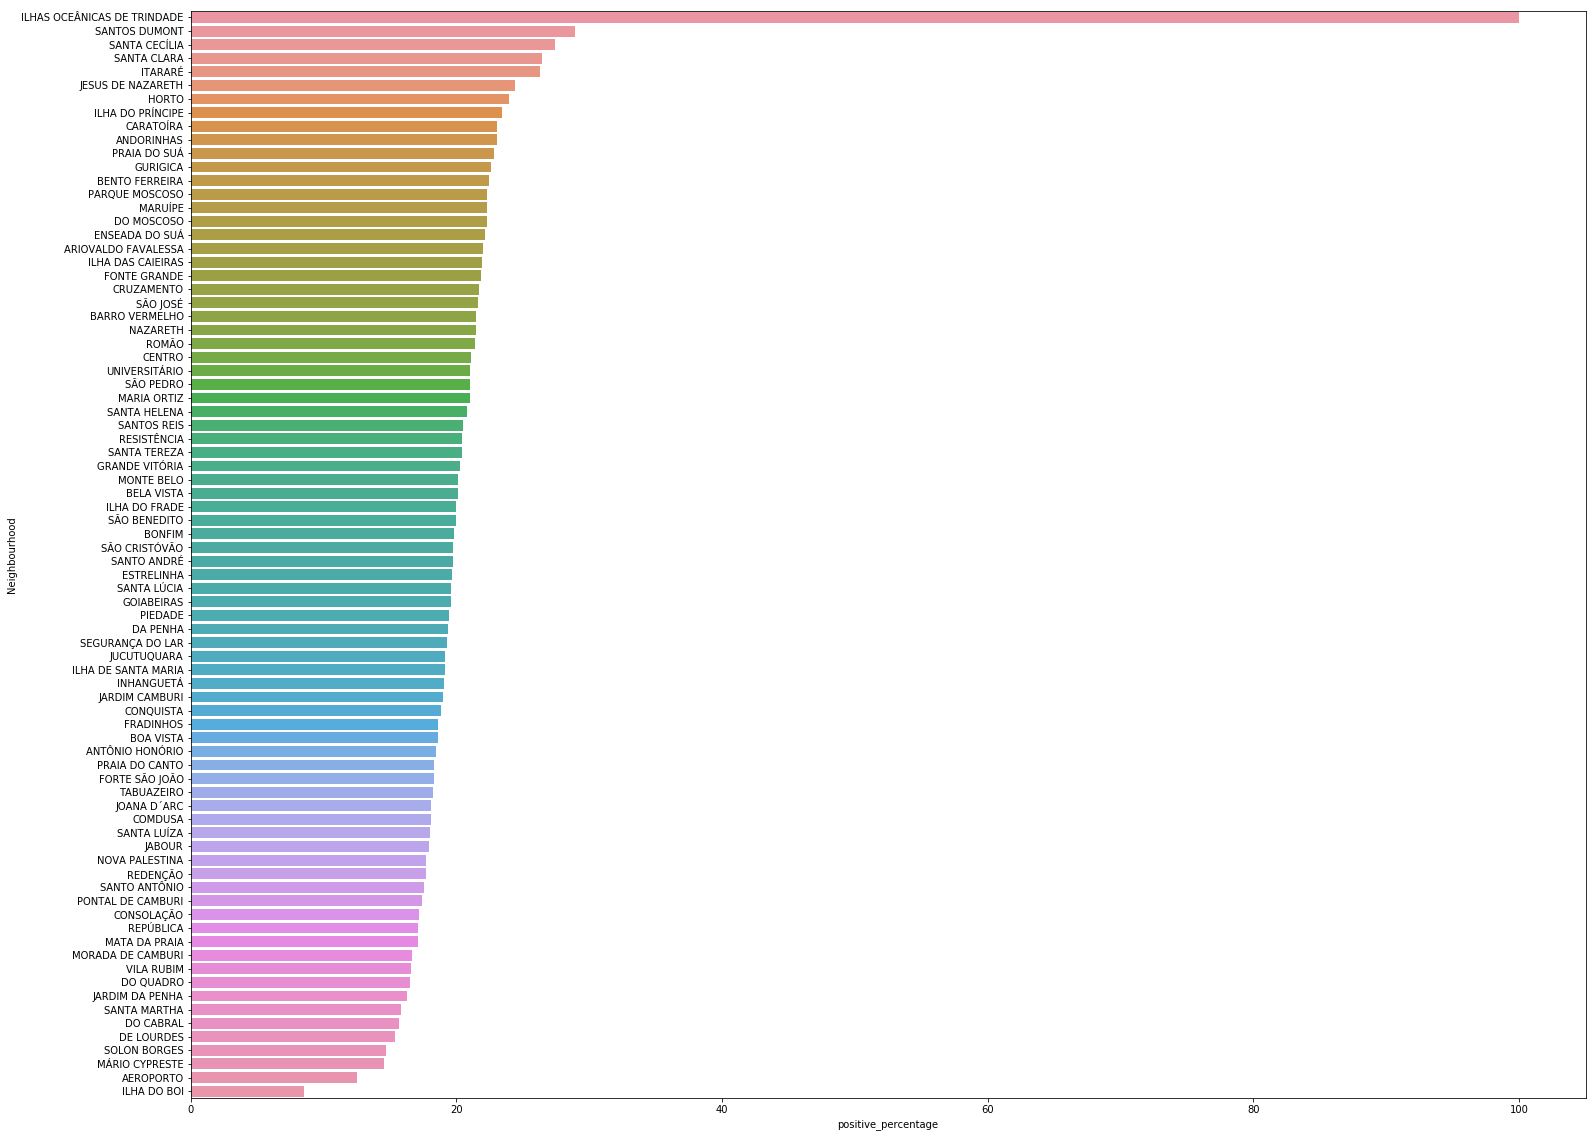

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(25, 20))

ax = sns.barplot(x="positive_percentage", y="Neighbourhood", data=neighbourhood_df)
plt.show()

<a id='conclusions'></a>
## Conclusions
During the Exploratory Data Analysis stage I've had the chance to dive into these medical appointments dataset. First things first, the dataset is, in terms of temporal range, limited. More than 110K samples distributed in 27 different days between end of April 2016 and beginning of June 2016. Therefore, no appropriate seasonality/temporal analysis could be driven.

The dataset contained patients from different age groups from 0 to 115 years old that had medical appointment the same day or several days from the day scheduling day. The main purpose was to investigate what sort of factors drived those patients to not to show up to their appointments. 

Along the way I've noticed slightly interesting linear relationships between variables such as the age of the patient and the existance of diseases such as Diabetes or Hipertension or the amount of days between the scheduling and appointment date with whether or not the patient recceived an SMS alert, which, if further analyzed, could lead us to a better understanding of how this system works (Currently, I'm not sure if this is an automatic system available for any patient requesting it or just for a particular group of patients). Some correlation was also spotted between the dependant variable and the amount of days between the scheduling and the appointment. Obviously, none of these relationships are enough to state any sort of causality but they are interesing to get a grasp on the particularities of our sample and come up with questions to further analyze the data. 

I normalized the data to obtain relative percentage of positive samples per age groups, distance between scheduling and appointment days groups as well as gender. I found out that, in this particular sample, the relative percentage of positive samples nearly doubles once the number of days between the scheduling day and the appointment day is bigger than 15 days (from ~15% to ~30%). No remarkable differences were spotted between gender groups nor age groups, except between teenagers and senior adults, with higher relative percentage of positive samples for the former. It is obvious that the potential risk of not showing to a medical appointment is higher for older people than for teenagers. 

Finally, I included the same relative percentage study for different neighbourhoods. For example,the percentage of positive samples in SANTOS DUMONT is much higher (~30%) than in other neighbourhoods such as ILHA DO BOI (~8%). It could be interesting to understand if this has something to do with the demographics in each neighbourhood.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [46]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0